<a href="https://colab.research.google.com/github/KKobuszewski/aluminium-prediction/blob/main/notebooks/Fractional_Brownian_Motion_reconstruct_hurst_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multifractional Brownian and Levy Motion

## Sources

http://www.columbia.edu/~ad3217/fbm/thesis.pdf

https://en.wikipedia.org/wiki/Fractional_Brownian_motion

[Fractional Levy Motion](https://flm.readthedocs.io/en/latest/)

https://flynn.gg/blog/adding-multifractional-support-to-fbm/

https://pypi.org/project/fbm/

https://github.com/crflynn/fbm/blob/master/fbm/mbm.py

## Install required packges

In [ ]:
!pip install fbm

## Mount drive & import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Kurs ML & AI'/'Stock analysis'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kurs ML & AI/Stock analysis
 al_production_data.csv
'ALU-LME (Metals-API).csv'
'Aluminium data.ipynb'
'Aluminium Historical Data.csv'
'Aluminium production.ipynb'
'Fractional Brownian Motion.ipynb'
 hurst1_func.pkl
 hurst1_mbm.16384.npy
 hurst1_mbm.32768.npy
 hurst1_mbm.4096.npy
'Hurst dynamiquev3_240528_142233.pdf'
 hurst_func.pkl
'Levy processes.ipynb'
'LSTM Stock prediction.ipynb'
'Plotly example.ipynb'
'Projekt dane finansowe.gdoc'
 SCLim_Modelinglocallyself-similar_240527_141335.pdf
 SCLim_Modelinglocallyself-similar.pdf
 sde_240317_161637.pdf
'Stochastic differential equation - numerical integration.ipynb'


In [ ]:
import pickle

import numpy as np
import scipy.interpolate
import scipy.stats

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

import statsmodels.nonparametric.kernel_regression

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import fbm

from IPython.display import HTML

In [ ]:
cpu_info = !lscpu
for inf_item in cpu_info.get_list():
  print(inf_item)

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

## Define a Hurst function

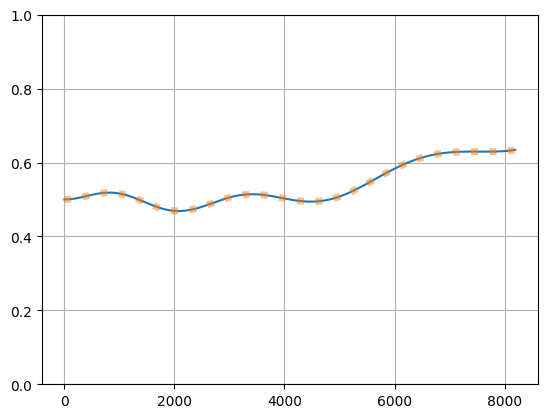

In [ ]:
# Define a hurst function
def h(t):
    return 0.5 * np.sin(3*t**3+5*t**2-20*t)*(t*(t-0.5)) + 0.5

#print(h.__code__)


with open('hurst_func.pkl', mode='wb') as f:
  pickle.dump(h, f)

with open('hurst_func.pkl', mode='rb') as f:
  func = pickle.load(f)


n = 1024*8
t = np.linspace(0.0,1.0,n+1)

plt.grid(True)
plt.ylim([0.0,1.0])
plt.plot(h(t))
plt.plot(func(t), linestyle=':', linewidth=5, alpha=0.5)
plt.show()

## Generate MBM sample and save to the drive

In [ ]:

for n in [1024*4,1024*16, 1024*32]:
  # Generate a mbm realization
  m = fbm.MBM(n=n, hurst=h, length=1, method='riemannliouville')
  mbm_sample = m.mbm()

# Get the times associated with the mBm
t_values = m.times()

fig, axes = plt.subplots(ncols=1,nrows=2, sharex=True, figsize=[12.,12.])
ax1, ax2 = axes.ravel()

ax1.grid(True)
ax1.plot(mbm_sample)

ax2.grid(True)
ax2.plot(h(t_values))

plt.show()

SyntaxError: expected ':' (<ipython-input-10-a82e1de320f2>, line 1)

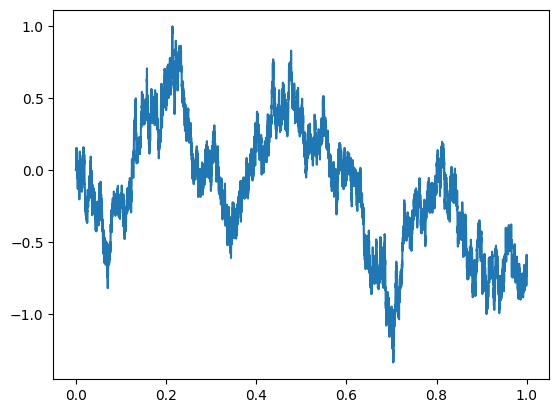

In [ ]:
m = fbm.FBM(n=1024*8, hurst=0.35, length=1, method='daviesharte')
fbm_sample = m.fbm()

# Get the times associated with the mBm
t_values = m.times()

plt.plot(t_values, fbm_sample)
plt.show()

## Recovering H(t)

Following paper [Physical Review E 63(4 Pt 2):046104](https://www.researchgate.net/publication/12025517_Modeling_of_locally_self-similar_processes_using_multifractional_Brownian_motion_of_Riemann-Liouville_type) we can estimate generalized Holder/Hurst exponent with

$$
S_k(j) = \frac{m}{N-1}\sum_{i=j-k}^{i=j+k} \left\vert X_{i+1} - X_{i} \right\vert~, \qquad 1 < k < N/2, \qquad m = \left\lfloor \frac{N}{2k} \right\rfloor
$$

$X_i$ - i-th sample of the signal?

$$
H_j = - \frac{\ln\left[ \sqrt{\pi/2} ~ S_k(j) \right]}{\ln(m-1)}
$$

What is timespacing?

In [ ]:
def S_kj(X, k):
  N = int(X.size)
  m = int(np.floor(N/k))
  S = np.zeros(N,dtype=X.dtype)
  for j in range(k, N-k-2):
    S[j-k] = m/float(N-1) * np.abs(X[j-k+1:j+k+1]-X[j-k:j+k]).sum()
  return S

def h_exponent(X, k_max=10):
  N = int(X.size)
  S = np.zeros([k_max,N],dtype=X.dtype)
  H = np.zeros([k_max,N],dtype=X.dtype)
  for k in range(1,k_max+1):
    m = int(np.floor(N/k))
    for j in range(k, N-k-2):
      S[k-1,j] = m/float(N-1) * np.abs(X[j-k+1:j+k+1]-X[j-k:j+k]).sum()
      H[k-1,j] = - np.log( np.sqrt(0.5*np.pi) * S[k-1,j] ) / np.log(m-1)

  return H


def estimate_hurst_exponent(X, k_max=10, return_pdensity=False):
  t = np.linspace(0.0,1.0,X.size)

  # get data to fit
  H = h_exponent(X, k_max=k_max)
  H_to_fit = []
  t_to_fit = []
  for k in range(1,11):
    idx = np.where(H[k-1,:] > 1e-15)[0]
    H_to_fit.append(H[k-1,idx])
    t_to_fit.append(t[idx])# + 1e-10*(k-1))
  H_to_fit = np.concatenate(H_to_fit)
  t_to_fit = np.concatenate(t_to_fit)
  idx = np.argsort(t_to_fit)
  H_to_fit = H_to_fit[idx]
  t_to_fit = t_to_fit[idx]

  # grid for kernel estimation of probability density
  h_max = max([1.0,H.max()])
  h, T = np.meshgrid(np.linspace(0.0,h_max,128), t, indexing='ij', sparse=False)

  # estimate density probability with gaussian kernels
  positions = np.vstack([h.ravel(), T.ravel()])
  values = np.vstack([H_to_fit, t_to_fit])
  kernel = scipy.stats.gaussian_kde(values)

  prob = np.reshape(kernel(positions).T, T.shape)

  # get most probable values of Hurst exponent for each timestamp
  h_estimated = []
  for it in range(prob.shape[1]):
    prob[:,it] /= prob[:,it].sum()  # normalize probability for each time
    h_estimated.append( h[np.argmax(prob[:,it]),it] )

  if return_pdensity is False:
    return np.array(h_estimated)
  else:
    return np.array(h_estimated), h, T, prob


(20, 4097)
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.] (20,)


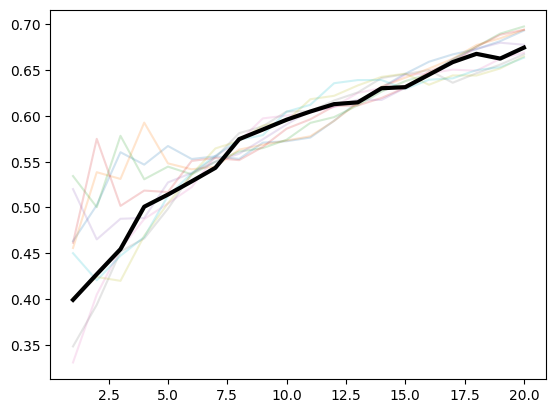

In [ ]:
n = 4096
X = np.load('hurst1_mbm.4096.npy')
#with open('hurst_func.pkl', mode='rb') as f:
#  func = pickle.load(f)
# Define a hurst function
def hurst(t):
    return 0.5 * np.sin(3*t**3+5*t**2-20*t)*(t*(t-0.5)) + 0.5
t = np.linspace(0.0,1.0,n+1)

k_max=20
H = h_exponent(X, k_max=k_max)
print(H.shape)

k_ = np.linspace(1,k_max,k_max,endpoint=True)
print(k_,k_.shape)

it = 100
plt.plot(k_, H[:, it-5:it+5], alpha=0.2)
plt.plot(k_, H[:, it], color='k', linewidth=3)
plt.show()




[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 2.44140625e-04 4.88281250e-04 ... 9.99511719e-01
  9.99755859e-01 1.00000000e+00]]


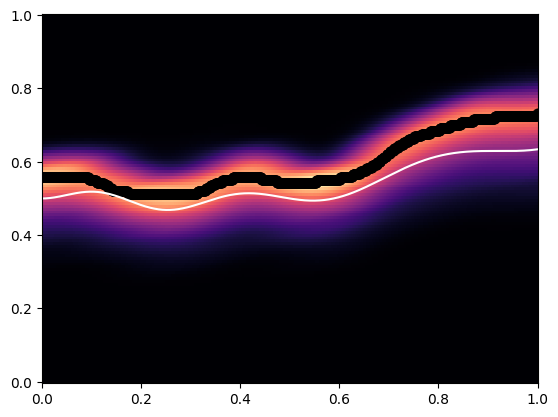

In [ ]:
n = 4096
X = np.load('hurst1_mbm.4096.npy')
#with open('hurst_func.pkl', mode='rb') as f:
#  func = pickle.load(f)
# Define a hurst function
def hurst(t):
    return 0.5 * np.sin(3*t**3+5*t**2-20*t)*(t*(t-0.5)) + 0.5
t = np.linspace(0.0,1.0,n+1)

k_max=20
H = h_exponent(X, k_max=k_max)

h, T = np.meshgrid(np.linspace(0.,1.,128), t, indexing='ij', sparse=False)
#print(h.shape, T.shape)
H_to_fit = []
t_to_fit = []

for k in range(1,11):
  idx = np.where(H[k-1,:] > 1e-15)[0]
  H_to_fit.append(H[k-1,idx])
  t_to_fit.append(t[idx])# + 1e-10*(k-1))
H_to_fit = np.concatenate(H_to_fit)
t_to_fit = np.concatenate(t_to_fit)
idx = np.argsort(t_to_fit)
H_to_fit = H_to_fit[idx]
t_to_fit = t_to_fit[idx]



positions = np.vstack([h.ravel(), T.ravel()])
print(positions)

values = np.vstack([H_to_fit, t_to_fit])
kernel = scipy.stats.gaussian_kde(values)

prob = np.reshape(kernel(positions).T, T.shape)
h_estimated = []
for it in range(prob.shape[1]):
  prob[:,it] /= prob[:,it].sum()  # normalize probability for each time
  h_estimated.append( h[np.argmax(prob[:,it]),it] )

plt.pcolor(T,h, prob, cmap='magma')
plt.plot(t,hurst(t), color='white', label='given H(t)')
plt.scatter(t, h_estimated, color='r', alpha=0.5, w=1, label='estimated H(t)')
plt.show()

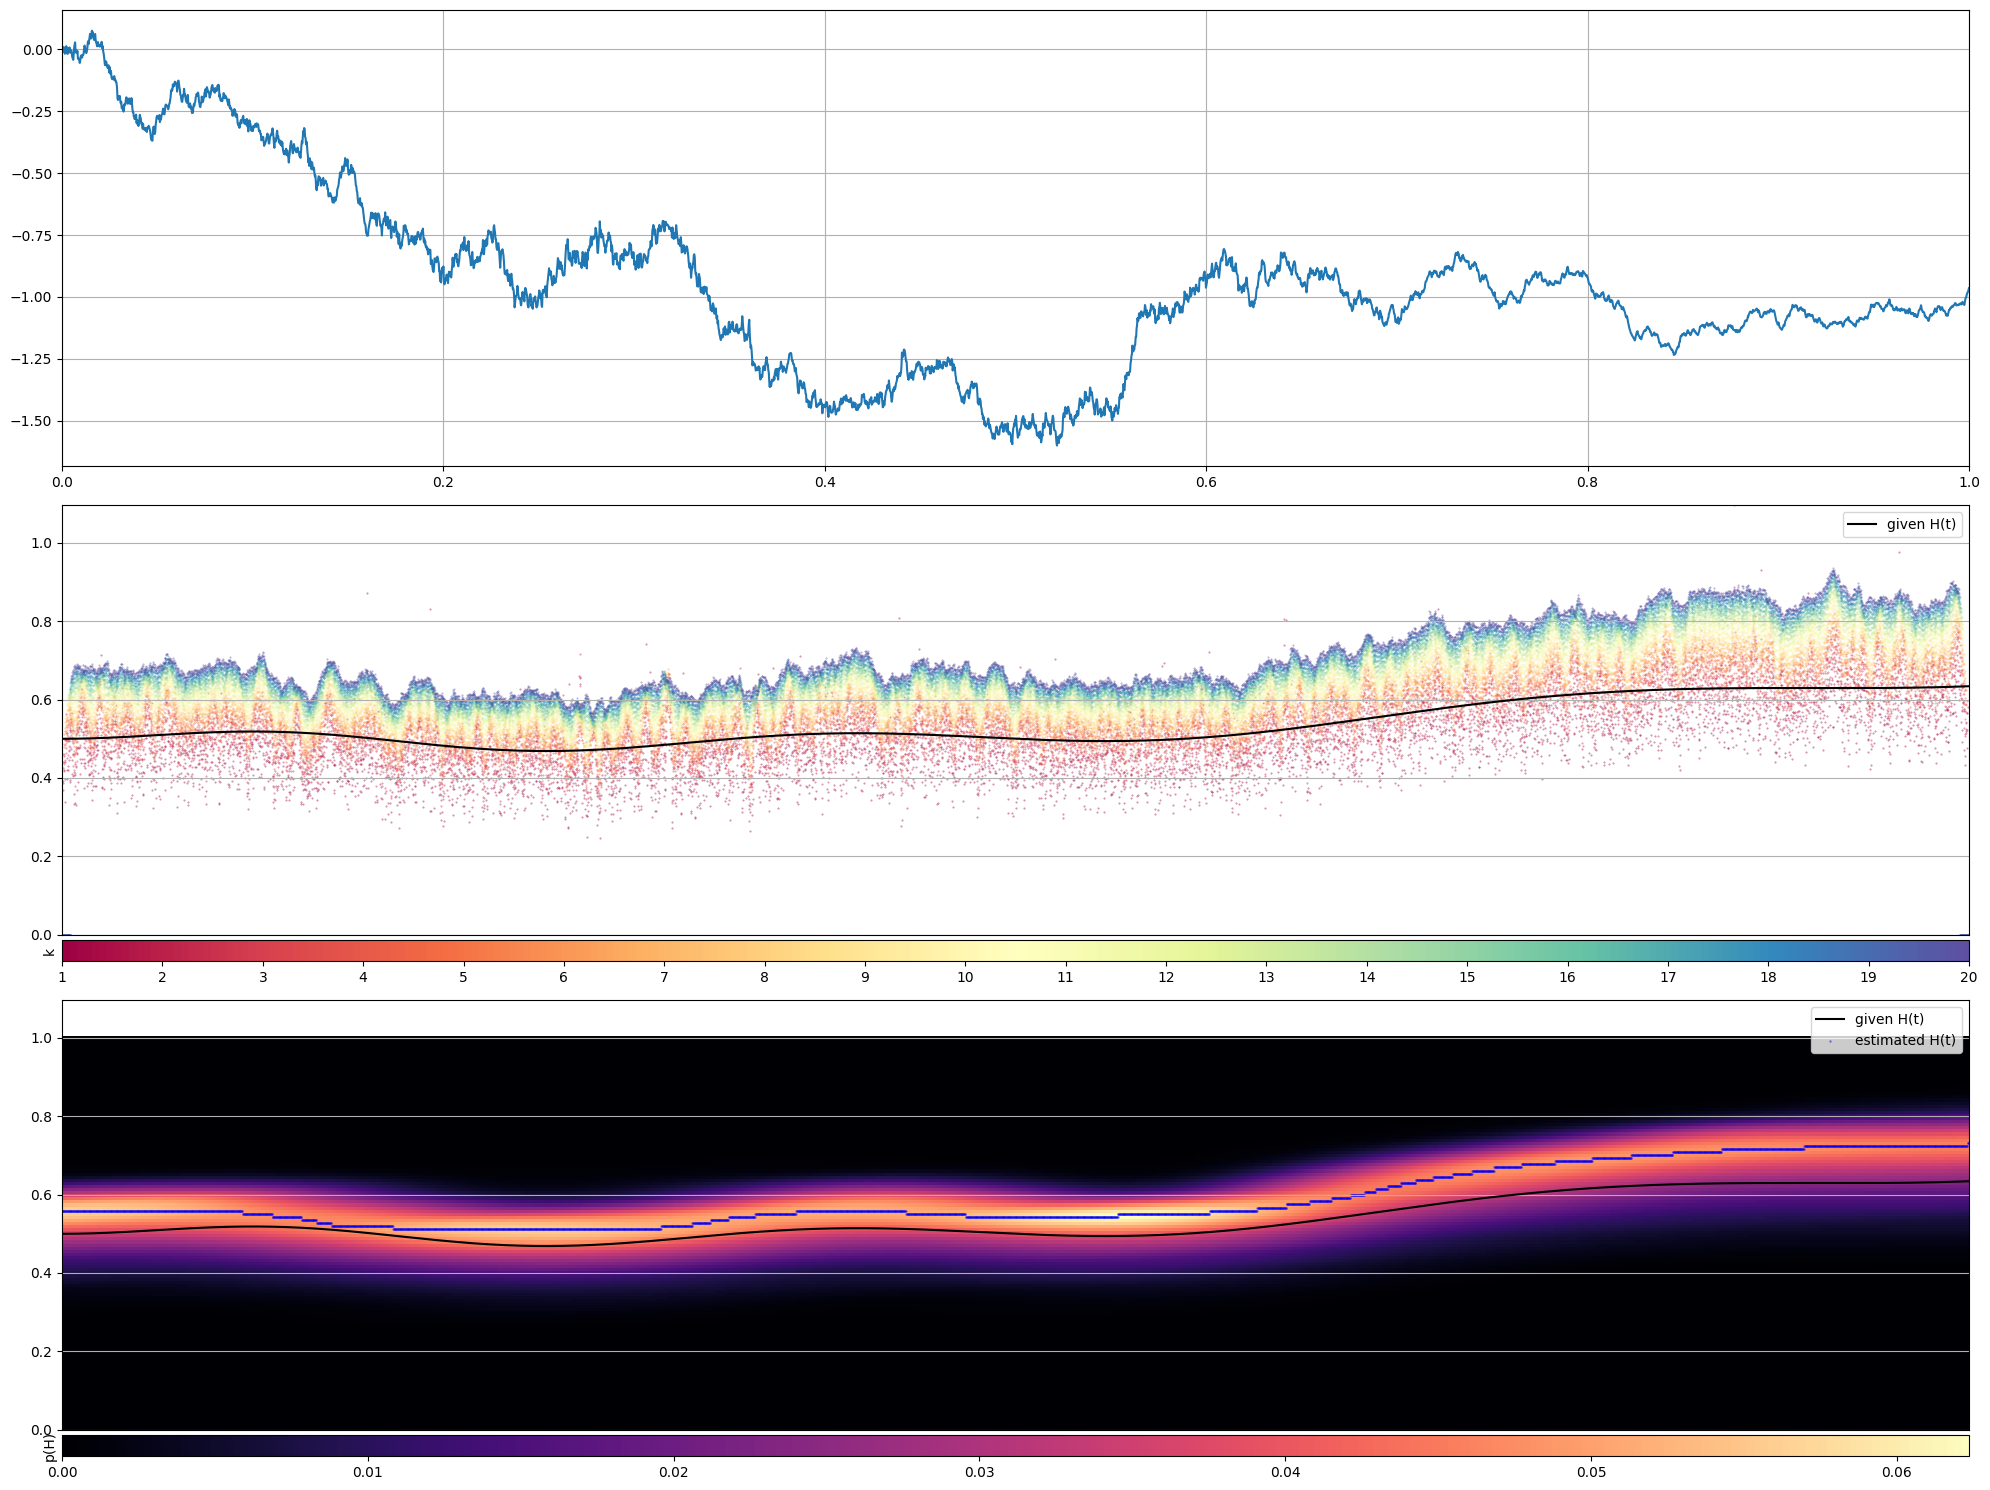

In [ ]:
n = 4096
X = np.load('hurst1_mbm.4096.npy')
#with open('hurst_func.pkl', mode='rb') as f:
#  func = pickle.load(f)
# Define a hurst function
def hurst(t):
    return 0.5 * np.sin(3*t**3+5*t**2-20*t)*(t*(t-0.5)) + 0.5
t = np.linspace(0.0,1.0,n+1)

k_max=20
H = h_exponent(X, k_max=k_max)
#h_estimated, h, T, prob = estimate_hurst_exponent(X, k_max=10, return_pdensity=False)
h_max = max([1.0,H.max()])

#cmap = matplotlib.cm.get_cmap('Spectral') # depricated
cmap = matplotlib.colormaps['Spectral']
norm = matplotlib.colors.Normalize(vmin=1.0, vmax=k_max)


fig, axes = plt.subplots(ncols=1, nrows=3, figsize=[20.,15.])
ax1, ax2, ax3 = axes.ravel()

ax1.grid(True)
#ax1.set_xlim([-0.5,4096.5])
ax1.set_xlim([0.0,1.0])
ax1.plot(t, X)

ax2.grid(True)
ax2.set_ylim([0.0,h_max])
ax2.set_xlim([0.0,1.0])
ax2.set_xticks([])
ax2.set_xticks([], minor=True)
#pc = ax2.pcolor(H, cmap='magma')
for k in range(1,k_max+1):
  ax2.scatter(t, H[k-1,:], s=0.2, alpha=0.5, color=cmap(norm(k))) #, label=f'{k=}'
ax2.plot(t, hurst(t), color='k', label='given H(t)')
cax2 = make_axes_locatable(ax2).append_axes('bottom', size='5%', pad=0.05)
cb2  = matplotlib.colorbar.ColorbarBase(cax2, cmap=cmap, norm=norm, orientation='horizontal')
cb2.ax.set_ylabel('k')
cb2.ax.get_xaxis().set_ticks(np.arange(1,H.shape[0]+1))
ax2.legend()

ax3.grid(True)
ax3.set_ylim([0.0,h_max])
ax3.set_xlim([0.0,1.0])
ax3.set_xticks([])
ax2.set_xticks([], minor=True)

pc = ax3.pcolor(T,h, prob, cmap='magma')
ax3.plot(t,hurst(t), color='k', label='given H(t)')
ax3.scatter(t, h_estimated, color='b', alpha=0.3, s=1, label='estimated H(t)')

cax3 = make_axes_locatable(ax3).append_axes('bottom', size='5%', pad=0.05)
cb3 = fig.colorbar(pc, cax=cax3, orientation='horizontal')
cb3.ax.set_ylabel('k')
cb3.ax.set_ylabel('p(H)')
ax3.legend()

#h_estimate = scipy.interpolate.make_smoothing_spline(t_to_fit, H_to_fit)

#model = KernelRidge(alpha=0.1, kernel='rbf', gamma=1.0)
#model.fit(t_to_fit, H_to_fit)

# see https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py
#kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
#gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(t_to_fit, H_to_fit)
#mean_predictions_gpr, std_predictions_gpr = gpr.predict(t, return_std=True,)

#ax3.plot(t, mean_predictions_gpr)
#ax3.plot(t, mean_predictions_gpr)


fig.tight_layout()
plt.show()

### Better estimation?

[M. Garcin, *Estimation of time-dependent Hurst exponents with variational smoothing and application to forecasting foreign exchange rates*](https://hal.science/hal-01399570/document)


$$
M_{q}(t) = \frac{1}{k}\sum_{i=0}^{k-1}\left\vert X\left(t-\frac{i}{N}\right) - X\left(t-\frac{i+1}{N}\right) \right\vert^q
$$
$$
M'_{q}(t) = \frac{2}{k}\sum_{i=0}^{k/2-1}\left\vert X\left(t-\frac{2i}{N}\right) - X\left(t-\frac{2(i+1)}{N}\right) \right\vert^q
$$

$X(t)$ - signal, $t\in[0,1]$

$1 < k < N$

It is suposed to use $q=2$.

Then estimator of Hurst exponent is given by
$$
H(t) \approx \frac{1}{2} \log_2 \frac{M_2(t)}{M'_2(t)}
$$



In [ ]:
def h_exponent2(X, k_min, k_max):
